In [1]:
using Pkg
Pkg.activate((@__DIR__) * "/../one_flav_env")

using LHEF
using LorentzVectorHEP
using DataFrames
using CSV
using StaticArrays
using LinearAlgebra
using LaTeXStrings
using DelimitedFiles: readdlm
using Optim
using PythonPlot

golden_ratio = (1+sqrt(5))/2

rc("font", family="serif", serif="Computer Modern", size=14)
rc("figure", autolayout=true)
rc("axes", labelsize=16, unicode_minus=false)
rc("text", usetex=true)
rc("text.latex", preamble=raw"\usepackage{slashed}")

MG_RESULTS_DIR = (@__DIR__) * "/../madgraph/data/"
FIGDIR = "./"

# make sure these match what the script has output
DIR_llνν = MG_RESULTS_DIR * "mumu_to_llvv/"

PROMPT_DIR = "prompt/"
DIR_φφ = MG_RESULTS_DIR * PROMPT_DIR * "mumu_to_phiphi/"
DIR_llχχ = MG_RESULTS_DIR * PROMPT_DIR * "mumu_to_llchichi/"
DIR_VVφφ = MG_RESULTS_DIR * PROMPT_DIR * "VV_to_phiphi/"
DIR_VVχχ = MG_RESULTS_DIR * PROMPT_DIR * "VV_to_llchichi/"

RUN_RESULTS_FILENAME = "run_info.csv"
SUMMARY_FILENAME = "dilepton_summary.csv"
;

  Activating project at `~/Dropbox (University of Oregon)/MuC/Aria/one_flav/code/one_flav_env`


In [2]:
include((@__DIR__) * "/prompt_utils.jl")
using .Prompt
;

In [ ]:
function dir_runx(x)
    if x < 10
        return "Events/run_0$x/"
    else
        return "Events/run_$x/"
    end
end

function load_summary(rundir)
    Matrix(CSV.read(rundir*SUMMARY_FILENAME, DataFrame))'
end

function load_run_info(mgdir)
    CSV.read(mgdir*RUN_RESULTS_FILENAME, DataFrame)
end

function get_bkg_at_rts(rts_tev, bkg_dir)
    rts_gev = Float64(rts_tev)*1e3

    run_info = load_run_info(bkg_dir)
    idxs = findall(x -> x == rts_gev, run_info[:,1])
    run_info = run_info[idxs,:]

    if length(idxs) > 1
        throw(ArgumentError("too many bkgs"))
    else
        bkg_summary = load_summary(bkg_dir*dir_runx(idxs[1]))
    end

    return run_info, bkg_summary
end
;

In [6]:
function get_runs_at_rts(rts_tev; bkg_dir=DIR_llνν, mumu_dir=DIR_llχχ, 
    vbf_dir=DIR_VVχχ)

    rts_gev = Float64(rts_tev)*1e3

    mumu_info = load_run_info(mumu_dir)
    vbf_info = load_run_info(vbf_dir)

    mumu_idxs = findall(x -> x == rts_gev, mumu_info[:,1])
    vbf_idxs = findall(x -> x == rts_gev, vbf_info[:,1])

    if !(mumu_idxs == vbf_idxs)
        throw(ArgumentError("mumu and vbf runs don't match up..."))
    end

    mumu_info = mumu_info[mumu_idxs,:]
    vbf_info = vbf_info[vbf_idxs,:]

    bkg_info, bkg_summary = get_bkg_at_rts(rts_tev, bkg_dir)

    mumu_summaries = load_summary.(mumu_dir .* dir_runx.(mumu_idxs))
    vv_summaries = load_summary.(vbf_dir .* dir_runx.(vbf_idxs))

    return (rts=rts_gev, run_ids=mumu_idxs, mphis=mumu_info.mphi,
            mumu_xsecs=mumu_info.xsec, vv_xsecs=vbf_info.xsec,
            bkg_summary=bkg_summary, bkg_xsec=bkg_info.xsec[1],
            mumu_summaries=mumu_summaries, vv_summaries=vv_summaries)
end

function get_run_at_mphi(rts_runs, mphi_tev)
    mphi_gev = mphi_tev*1e3

    idx = 0

    for (i,m) in enumerate(rts_runs.mphis)
        if m == mphi_gev
            idx = i
        end
    end

    return (rts=rts_runs.rts, mphi=rts_runs.mphis[idx],
    bkg_summary=rts_runs.bkg_summary, bkg_xsec=rts_runs.bkg_xsec,
    mumu_summary=rts_runs.mumu_summaries[idx],
    mumu_xsec=rts_runs.mumu_xsecs[idx], vv_summary=rts_runs.vv_summaries[idx],
    vv_xsec=rts_runs.vv_xsecs[idx])
end
;

In [4]:
rts10_runs = get_runs_at_rts(10)
rts3_runs = get_runs_at_rts(3)
;

In [7]:
rts10_mphi45_run = get_run_at_mphi(rts10_runs, 4.5)
rts10_mphi1_run = get_run_at_mphi(rts10_runs, 1)
rts3_mphi1_run = get_run_at_mphi(rts3_runs, 1)
rts3_mphi13_run = get_run_at_mphi(rts3_runs, 1.3)
;

# 1D Histograms

In [ ]:
function run_hist(rts_runs_1, rts_runs_2; binsize=[50, 100])
    mphi_idxs_1 = [1,length(rts_runs_1.mphis)]
    mphi_idxs_2 = [1,length(rts_runs_2.mphis)]

    mumu_summaries = [rts_runs_1.mumu_summaries[mphi_idxs_1],
                      rts_runs_2.mumu_summaries[mphi_idxs_2]]
    vv_summaries = [rts_runs_1.vv_summaries[mphi_idxs_1],
                    rts_runs_2.vv_summaries[mphi_idxs_2]]
    bkg_summary = [rts_runs_1.bkg_summary, rts_runs_2.bkg_summary]

    stitle = L"i \to l^+ l^- + \slashed{E}_T"
    labels = ["Background"]

    mphis = unique(vcat(rts_runs_1.mphis[mphi_idxs_1],
                        rts_runs_2.mphis[mphi_idxs_2]))

    for m in mphis
        push!(labels, L"Signal, $m_\phi = %$(1e-3*m)$ TeV")
    end

    yscales = ["log", "log", "log"]
    xlabels = [L"$m_{\ell \ell}$ [TeV]", L"$p_{T,\ell \ell}$ [TeV]", L"$M_{T2}$ [TeV]"]
    ylims = [(1e1, 1e5), (1e1, 1e5), (1e1, 1e5)]

    colors = [["tab:blue", "tab:orange"], ["tab:blue", "tab:red"]]
    linestyles = ["solid", "dashed"]
    
    fig, axs = subplots(3,2, figsize=(9, 9))

    s_i = [1,2,5]
    iter = 1
    for ax in axs
        for (j,a) in enumerate(ax)
            
            eachmin = [minimum(sig_summ[s_i[iter],:]) for sig_summ in mumu_summaries[j]]
            eachmin2 = [minimum(sig_summ[s_i[iter],:]) for sig_summ in vv_summaries[j]]
            binmin = min(eachmin..., eachmin2..., minimum(bkg_summary[j][s_i[iter],:]))

            eachmax = [maximum(sig_summ[s_i[iter],:]) for sig_summ in mumu_summaries[j]]
            eachmax2 = [maximum(sig_summ[s_i[iter],:]) for sig_summ in vv_summaries[j]]
            binmax = max(eachmax..., eachmax2..., maximum(bkg_summary[j][s_i[iter],:]))

            binns = 1e-3 .* range(0, binmax+binsize[j]; step=binsize[j])

            a.hist(1e-3 .* bkg_summary[j][s_i[iter],:], bins=binns, color="grey",
                histtype="step", density=false)

            for (i,sig_summ) in enumerate(mumu_summaries[j])
                a.hist(1e-3 .* sig_summ[s_i[iter],:], bins=binns, color=colors[j][i],
                    linestyle=linestyles[1], histtype="step", density=false)
            end

            for (i,sig_summ) in enumerate(vv_summaries[j])
                a.hist(1e-3 .* sig_summ[s_i[iter],:], bins=binns, color=colors[j][i],
                    linestyle=linestyles[2], histtype="step", density=false)
            end
            
            a.set_yscale(yscales[iter])

            a.set_xlabel(xlabels[iter])
            a.set_ylabel("Number of Events")

            a.grid(alpha=0.3)

            a.set_xlim((0, binns[end]))
            a.set_ylim(ylims[iter])
        end
        iter += 1
    end

    axs[0,0].plot(0, Inf, lw=1., c="grey", label=labels[1])
    for i in eachindex(mphis)
        axs[0,0].plot(0, Inf, lw=1., c=["tab:blue", "tab:orange", "tab:red"][i], label=labels[i+1])
    end

    axs[0,0].plot(0, Inf, lw=1., c="black", label=L"i = \mu^+ \mu^-")
    axs[0,0].plot(0, Inf, lw=1., c="black", ls="dashed", label=L"$i = $VBF")

    handles, labels = axs[0,0].get_legend_handles_labels()

    axs[0,0].set_title(L"$\sqrt{s} = %$(rts_runs_1.rts*1e-3)$ TeV")
    axs[0,1].set_title(L"$\sqrt{s} = %$(rts_runs_2.rts*1e-3)$ TeV")

    fig.legend(handles, labels, loc="lower center", ncol=3, fontsize=12)

    tight_layout(rect=(0, .05, 1, 1.02))

    plotclose()
    return fig
end
;

In [ ]:
hist_fig = run_hist(rts3_runs, rts10_runs; binsize=[50,200])
# hist_fig.savefig(FIGDIR * "prompt_1d_hist.pdf", bbox_inches="tight")
hist_fig

# Maximize over cuts:

In [10]:
function fraction_cuts(summary, mins)
    min_mll = mins[1]
    min_ptll = mins[2]
    min_mt2 = mins[3]

    frac_cut = sum((summary[1,:] .> min_mll) .&& (summary[2,:] .> min_ptll)
                    .&& (summary[5,:] .> min_mt2)) ./ length(summary[1,:])
    
    return frac_cut
end

function N_signal(run, lumi, mins)
    N_mumu = run.mumu_xsec * lumi * fraction_cuts(run.mumu_summary, mins)
    N_vv = run.vv_xsec * lumi * fraction_cuts(run.vv_summary, mins)

    return N_mumu+N_vv
end

function N_background(run, lumi, mins)
    N_bkg = run.bkg_xsec * lumi * fraction_cuts(run.bkg_summary, mins)
end

function significance(run, lumi, mins)
    mumu_frac = fraction_cuts(run.mumu_summary, mins)
    vv_frac = fraction_cuts(run.vv_summary, mins)
    bkg_frac = fraction_cuts(run.bkg_summary, mins)

    N_mumu = run.mumu_xsec * lumi * mumu_frac
    N_vv = run.vv_xsec * lumi * vv_frac
    N_bkg_true = run.bkg_xsec * lumi * bkg_frac
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)

    N_S = N_mumu + N_vv

    if N_S <= 20
        N_S = 0.0
    end

    return N_S / sqrt(N_bkg)
end

function gtr_min(summ_vec, min)
    summ_vec .> min
end

function fcut(summary, mll_min, ptll_min, mt2_min)
    N_mll = length(mll_min)
    N_ptll = length(ptll_min)
    N_mt2 = length(mt2_min)
    Nevent = length(summary[1,:])

    res = zeros(Float64, (N_mll, N_ptll, N_mt2))

    mll_test = gtr_min.((summary[1,:],), mll_min)
    ptll_test = gtr_min.((summary[2,:],), ptll_min)
    mt2_test = gtr_min.((summary[5,:],), mt2_min)

    @Threads.threads for i in 1:N_mll
        @Threads.threads for j in 1:N_ptll
            @Threads.threads for k in 1:N_mt2
                res[i,j,k] = sum(mll_test[i] .&& ptll_test[j] .&& mt2_test[k])
            end
        end
    end

    return res ./ Nevent
end
;

In [ ]:
function find_best_cuts_disc(run, lumi; ncuts=50, mincut=200.0, 
                             integer_cuts=true)

    if integer_cuts
        cuts = (Vector{Int}(round.(range(mincut, run.rts, ncuts); sigdigits=2)), 
            Vector{Int}(round.(range(mincut, run.rts/2, ncuts); sigdigits=2)), 
            Vector{Int}(round.(range(mincut, run.mphi, ncuts); sigdigits=2)))
    else
        cuts = (range(mincut, run.rts, ncuts), range(mincut, run.rts/2, ncuts), 
            range(mincut, run.mphi, ncuts))
    end

    frac_mumu = fcut(run.mumu_summary, cuts...)
    frac_vv = fcut(run.vv_summary, cuts...)
    frac_bkg = fcut(run.bkg_summary, cuts...)

    N_bkg_true = run.bkg_xsec.*lumi.*frac_bkg
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)
    bkg_err = sqrt.(N_bkg)
    N_mumu = run.mumu_xsec .* lumi .* frac_mumu
    N_vv = run.vv_xsec .* lumi .* frac_vv

    N_tot = N_mumu .+ N_vv

    for (i, n) in enumerate(N_tot)
        if n <= 20
            N_tot[i] = 0.0
        end
    end

    signif = N_tot ./ bkg_err

    idxs = argmax(signif)

    return [cuts[1][idxs[1]], cuts[2][idxs[2]], cuts[3][idxs[3]]], signif[idxs]
end

function make_table(rts_runs, lumi; ncuts=50)
    runs = get_run_at_mphi.((rts_runs,), 1e-3 .* [rts_runs.mphis[1], rts_runs.mphis[end]])
    bests = find_best_cuts_disc.(runs, lumi; ncuts=ncuts)

    best_cuts = [bests[1][1], 
                round.((bests[2][1] .+ bests[1][1]) ./ 2, sigdigits=2),
                bests[2][1]]

    nrows = 3*3*3
    sigs1_fordf = zeros(Float64, nrows)
    sigs2_fordf = zeros(Float64, nrows)
    cut1s = zeros(Int64, nrows)
    cut2s = zeros(Int64, nrows)
    cut3s = zeros(Int64, nrows)
    signal1 = zeros(Int64, nrows)
    signal2 = zeros(Int64, nrows)
    bkg1 = zeros(Int64, nrows)

    idx = 1
    for c1 in [best_cuts[i][1] for i in 1:3]
        for c2 in [best_cuts[i][2] for i in 1:3]
            for c3 in [best_cuts[i][3] for i in 1:3]
                cut1s[idx] = c1
                cut2s[idx] = c2
                cut3s[idx] = c3
                signal1[idx] = round(N_signal(runs[1], lumi, [c1, c2, c3]))
                signal2[idx] = round(N_signal(runs[2], lumi, [c1, c2, c3]))
                bkg1[idx] = round(N_background(runs[1], lumi, [c1, c2, c3]))
                sigs1_fordf[idx] = round(significance(runs[1], lumi, [c1, c2, c3]); sigdigits=3)
                sigs2_fordf[idx] = round(significance(runs[2], lumi, [c1, c2, c3]); sigdigits=3)
                idx += 1
            end
        end
    end

    mphi1_str = "mphi = $(1e-3 * rts_runs.mphis[1]) TeV"
    mphi2_str = "mphi = $(1e-3 * rts_runs.mphis[end]) TeV"

    return DataFrame("mll_min [GeV]" => cut1s, "ptll_min [GeV]" => cut2s, 
                    "mt2_min [GeV]" => cut3s,
                    "B" => bkg1,
                    "S ($mphi1_str)" => signal1,
                    "signif ($mphi1_str)" => sigs1_fordf,
                    "S ($mphi2_str)" => signal2,
                    "signif ($mphi2_str)" => sigs2_fordf)
end
;

In [ ]:
CSV.write("table_rts=3.csv", make_table(rts3_runs, 1e6, ncuts=100))
CSV.write("table_rts=10.csv", make_table(rts10_runs, 10e6, ncuts=100))
;

## 2D Cuts with best 3rd cut

In [11]:
SR_table_3 = CSV.read("table_rts=3.csv", DataFrame)
SR_table_10 = CSV.read("table_rts=10.csv", DataFrame)
SR_mins_3 = [Vector(SR_table_3[i,1:3]) for i in 1:nrow(SR_table_3)];
SR_mins_10 = [Vector(SR_table_10[i,1:3]) for i in 1:nrow(SR_table_10)];

function significances(run, lumi, mll_min, ptll_min, mt2_min)
    mumu_frac = fcut(run.mumu_summary, mll_min, ptll_min, mt2_min)
    vv_frac = fcut(run.vv_summary, mll_min, ptll_min, mt2_min)
    bkg_frac = fcut(run.bkg_summary, mll_min, ptll_min, mt2_min)

    N_mumu = run.mumu_xsec .* lumi .* mumu_frac
    N_vv = run.vv_xsec .* lumi .* vv_frac
    N_bkg_true = run.bkg_xsec .* lumi .* bkg_frac
    N_bkg = N_bkg_true .+ ((N_bkg_true .<= 2.0)*2.0)

    N_S = @. (N_mumu + N_vv)

    @. N_S *= (N_S >= 20)

    return N_S ./ sqrt.(N_bkg)
end

function make_best_cross_cuts_plot(run, lumi, best_cuts; ncuts=100)
    
    cuts = (range(0, run.rts, ncuts), range(0, run.rts/2, ncuts),
            range(0, maximum(run.mphi), ncuts))

    labels = [L"$m_{\ell \ell}$ min [TeV]", L"$p_{T,\ell \ell}$ min [TeV]",
              L"$M_{T2}$ min [TeV]"]

    sigs = zeros(Float64, (3, ncuts, ncuts))
    sigs[1,:,:] = significances(run, lumi, best_cuts[1], cuts[2], cuts[3])[1,:,:]
    sigs[2,:,:] = significances(run, lumi, cuts[1], best_cuts[2], cuts[3])[:,1,:]
    sigs[3,:,:] = significances(run, lumi, cuts[1], cuts[2], best_cuts[3])[:,:,1]

    x_idxs = [3,3,2]
    y_idxs = [2,1,1]

    fig, axs = subplots(3,1, figsize=(5, 10))

    for i in 1:3
        j = i-1
        xi = x_idxs[i]
        yi = y_idxs[i]

        q = axs[j].contourf(1e-3*cuts[xi], 1e-3*cuts[yi], sigs[i,:,:], 0:2:10, extend="max")

        axs[j].set_xlabel(labels[xi])
        axs[j].set_ylabel(labels[yi])

        axs[j].grid(alpha=0.3)

        axs[j].set_title(L"%$(labels[i][1:end-6]) = %$(round(1e-3*best_cuts[i], sigdigits=2)) TeV")

        axs[j].set_aspect((cuts[xi][end]-cuts[xi][1]) / ((cuts[yi][end]-cuts[yi][1])*golden_ratio), adjustable="box")

        fig.colorbar(q, label=L"S/\sqrt{B}")
    end

    fig.suptitle(L"$m_\phi$ = %$(run.mphi*1e-3) TeV, $\sqrt{s} = %$(1e-3*run.rts)$ TeV, $\mathcal{L} = %$(lumi*1e-6)$ ab$^{-1}$",
        fontsize=16)

    return fig
end
;

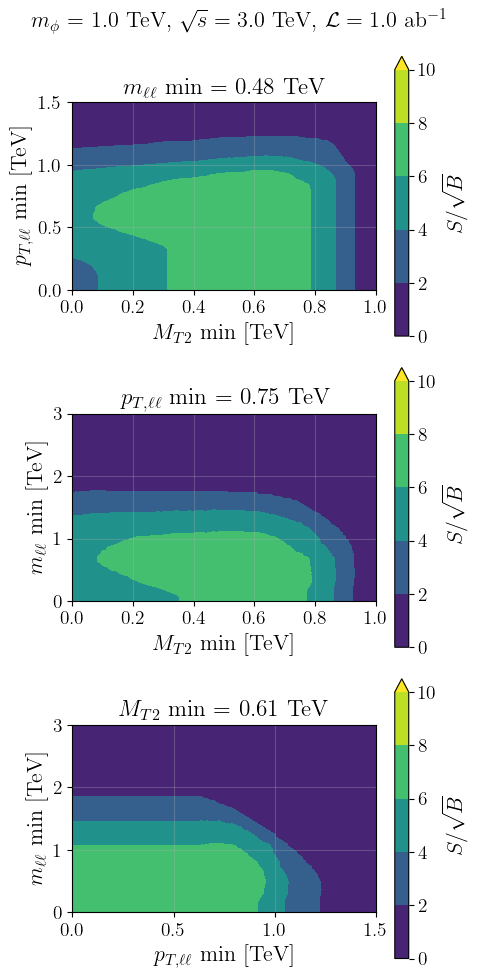

In [13]:
f1 = make_best_cross_cuts_plot(rts3_mphi1_run, 1e6, SR_mins_3[1])
# f1.savefig(FIGDIR*"best_signif_cross_rts=3_mphi=1.pdf", bbox_inches="tight")
f1

In [ ]:
f2 = make_best_cross_cuts_plot(rts3_mphi13_run, 1e6, SR_mins_3[end])
# f2.savefig(FIGDIR*"best_signif_cross_rts=3_mphi=1.3.pdf", bbox_inches="tight")
f2

In [ ]:
f3 = make_best_cross_cuts_plot(rts10_mphi1_run, 10e6, SR_mins_10[1])
# f3.savefig(FIGDIR*"best_signif_cross_rts=10_mphi=1.pdf", bbox_inches="tight")
f3

In [ ]:
f4 = make_best_cross_cuts_plot(rts10_mphi45_run, 10e6, SR_mins_10[end])
# f4.savefig(FIGDIR*"best_signif_cross_rts=10_mphi=4.5.pdf", bbox_inches="tight")
f4